In [1]:
!pip install -r requirements.txt

In [2]:
!pip install opencv-python

In [3]:
!pip install scikit-image

In [4]:
import os
import time
import random
import numpy as np
import scipy, multiprocessing
import tensorflow as tf
import tensorlayer as tl
from model import get_G, get_D
from config import config
from PIL import Image
import math

import pandas as pd

import matplotlib.pyplot as plt

from skimage import img_as_float
from skimage.measure import compare_ssim as ssim, compare_psnr as psnr

In [5]:
def PSNR(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [6]:
validate = None

In [ ]:
def evaluate(checkpoint_dir, model, valid_lr_img, valid_hr_img, G = None):

    valid_lr_img = (valid_lr_img / 127.5) - 1  # rescale to ［－1, 1]
    # print(valid_lr_img.min(), valid_lr_img.max())

    if not G:
        G = get_G([1, None, None, 3])
        G.load_weights(os.path.join(checkpoint_dir, model))
        G.eval()

    valid_lr_img = np.asarray(valid_lr_img, dtype=np.float32)
    valid_lr_img = valid_lr_img[np.newaxis,:,:,:]
    size = [valid_lr_img.shape[1], valid_lr_img.shape[2]]

    out = G(valid_lr_img).numpy()

    print("LR size: %s /  generated HR size: %s" % (size, out.shape))  # LR size: (339, 510, 3) /  gen HR size: (1, 1356, 2040, 3)
    print("[*] save images")
    #     tl.vis.save_image(out[0], os.path.join(save_dir, 'valid_gen.png'))
    #     tl.vis.save_image(valid_lr_img[0], os.path.join(save_dir, 'valid_lr.png'))
    #     tl.vis.save_image(valid_hr_img, os.path.join(save_dir, 'valid_hr.png'))

    out_bicu = scipy.misc.imresize(valid_lr_img[0], [size[0] * 4, size[1] * 4], interp='bicubic', mode=None)
    #     tl.vis.save_image(out_bicu, os.path.join(save_dir, 'valid_bicubic.png'))

    sr_smaller = tf.image.resize(out[0], size=size)
    hr_smaller = tf.image.resize(valid_hr_img, size=size)

    validate = {
        "sr" : out[0],
        "sr_resized" : sr_smaller.numpy(),
        
        "lr" : valid_lr_img[0],
        "bic" : out_bicu,
        
        "hr" : valid_hr_img, 
        "hr_resized" : hr_smaller.numpy(),
    }
    
    data = {
        "G" : G,
        
        "images" : validate,
        
#         "PSNR_lr" : PSNR( validate.get("lr"),  validate.get("sr_resized")),
        "psnr_lr" : psnr( validate.get("lr"),  validate.get("sr_resized")),
        "ssim_lr" : ssim(validate.get("lr"),  validate.get("sr_resized"), multichannel=True),

#         "PSNR_hr_4" : PSNR( validate.get("hr_resized"),  validate.get("sr_resized")),
        "psnr_hr_4" : psnr( validate.get("hr_resized"),  validate.get("sr_resized"), data_range = 255),
        "ssim_hr_4" : ssim(validate.get("hr_resized"),  validate.get("sr_resized"), multichannel=True),
        
#         "PSNR_hr" : PSNR( validate.get("hr"),  validate.get("sr")),
        "psnr_hr" : psnr( validate.get("hr"),  validate.get("sr")),
        "ssim_hr" : ssim(validate.get("hr"),  validate.get("sr"), multichannel=True),

#         "PSNR_bic_hr" : PSNR( validate.get("hr"),  validate.get("bic")),
        "psnr_bic_hr" : psnr( validate.get("hr"),  validate.get("bic")),
        "ssim_bic_hr" : ssim( validate.get("hr"),  validate.get("bic"), multichannel=True),
    }
    return data
       

In [8]:
###====================== PRE-LOAD DATA ===========================###
valid_hr_img_list = sorted(tl.files.load_file_list(path=config.VALID.hr_img_path, regx='.*.png', printable=False))
valid_lr_img_list = sorted(tl.files.load_file_list(path=config.VALID.lr_img_path, regx='.*.png', printable=False))

valid_lr_imgs = tl.vis.read_images(valid_lr_img_list, path=config.VALID.lr_img_path, n_threads=32)

valid_hr_imgs = tl.vis.read_images(valid_hr_img_list, path=config.VALID.hr_img_path, n_threads=32)

[TL] read 32 from DIV2K/DIV2K_valid_LR_difficult/
[TL] read 64 from DIV2K/DIV2K_valid_LR_difficult/
[TL] read 96 from DIV2K/DIV2K_valid_LR_difficult/
[TL] read 100 from DIV2K/DIV2K_valid_LR_difficult/
[TL] read 32 from DIV2K/DIV2K_valid_HR/
[TL] read 64 from DIV2K/DIV2K_valid_HR/
[TL] read 96 from DIV2K/DIV2K_valid_HR/
[TL] read 100 from DIV2K/DIV2K_valid_HR/


In [9]:
image_index = 0
image_index = image_index % len(valid_lr_img_list)

valid_lr_img = valid_lr_imgs[image_index]
valid_hr_img = valid_hr_imgs[image_index]

In [10]:
if validate:
    validate = evaluate("checkpoint","g-initial.h5",  valid_lr_img, valid_hr_img, G = validate.get("G"))
else:
    validate = evaluate("checkpoint","g-initial.h5",  valid_lr_img, valid_hr_img)
    

[TL] Input  _inputlayer_1: [1, None, None, 3]
[TL] Conv2d conv2d_1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_2: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_3: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_2: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_1: fn: add act: No Activation
[TL] Conv2d conv2d_4: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_5: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_4: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/skimage/measure/simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [11]:
def createPyPlot(validate_data, resized = True):


    label = 'SSIM: {:.2f}, sk_psnr:{:.2f} PSNR: {:.2f}'

    if resized: # show the images at size == the size of the input LR image
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17, 12),
                             sharex=True, sharey=True)
        ax = axes.ravel()
        
        ax[0].imshow(validate_data.get("images").get("lr"))
        ax[0].set_xlabel(label.format(1.00, 100.0, 100.0))
        ax[0].set_title('valid LR image')
        
        ax[1].imshow(validate_data.get("images").get("sr_resized"))
        ax[1].set_xlabel(label.format(validate_data.get("ssim_lr"), validate_data.get("psnr_lr"), validate_data.get("PSNR_lr")))
        ax[1].set_title('generated image resized *-4 vs LR image')
        
        ax[2].imshow(validate_data.get("images").get("hr_resized"))
        ax[2].set_xlabel(label.format(1.00, 100.0, 100.0))
        ax[2].set_title('valid HR resized *-4')      
        
        ax[3].imshow(validate_data.get("images").get("sr_resized"))
        ax[3].set_xlabel(label.format(validate_data.get("ssim_hr_4"), validate_data.get("psnr_hr_4"), validate_data.get("PSNR_hr_4")))
        ax[3].set_title('generated image resized *-4 vs HR resized')
        
    else: 
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 12),
                             sharex=True, sharey=True)
        ax = axes.ravel()
    
        ax[0].imshow(validate_data.get("images").get("hr"))
        ax[0].set_xlabel(label.format(1.00, 100.0, 100.0))
        ax[0].set_title('valid HR image')

        ax[1].imshow(validate_data.get("images").get("bic"))
        ax[1].set_xlabel(label.format(validate_data.get("ssim_bic_hr"), validate_data.get("psnr_bic_hr"), validate_data.get("PSNR_bic_hr")))
        ax[1].set_title('bicubic interpolation *4 vs HR')

        ax[2].imshow(validate_data.get("images").get("sr"))
        ax[2].set_xlabel(label.format(validate_data.get("ssim_hr"), validate_data.get("psnr_hr"), validate_data.get("PSNR_bic_hr")))
        ax[2].set_title('generated image vs HR')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


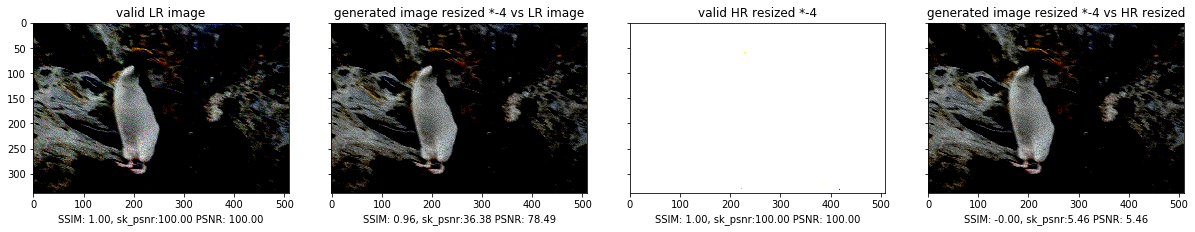

In [13]:
createPyPlot(validate, resized = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


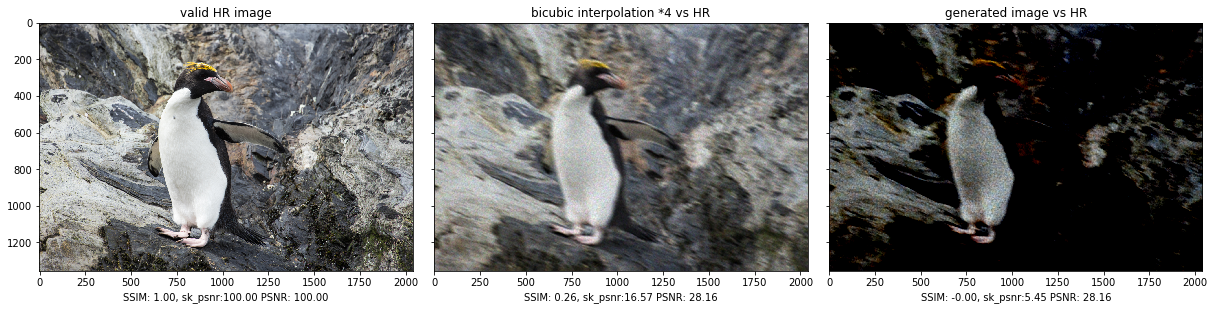

In [16]:
createPyPlot(validate, resized = False)

In [17]:
models = ["g-initial.h5"]

In [ ]:
validate_array = []
images = []
G = validate.get("G")

for model in range(len(models)):
    for image in range(len(valid_hr_img_list)):
        valid_lr_img = valid_lr_imgs[image]
        valid_hr_img = valid_hr_imgs[image]
        ev = evaluate("checkpoint",model,  valid_lr_img, valid_hr_img, G = G)
        
        images.append(ev.pop("images", None))
        G = ev.pop("G", G)
        validate_array.append(ev)
        break
    

LR size: [339, 510] /  generated HR size: (1, 1356, 2040, 3)
[*] save images


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [19]:
pd.DataFrame(validate_array)

,PSNR_lr,psnr_lr,ssim_lr,PSNR_hr_4,psnr_hr_4,ssim_hr_4,PSNR_hr,psnr_hr,ssim_hr,PSNR_bic_hr,psnr_bic_hr,ssim_bic_hr
0,78.492235,36.38203,0.964785,5.460319,5.460319,-0.000002,5.447076,5.447077,-0.002151,28.161118,16.570921,0.264711
